In [22]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS

## Chargement Dataset

In [23]:
df  = pd.read_pickle("df.pkl")


## Apercu des valeurs 

In [24]:
df.head()

,id,keyword,location,text,target,char_count,word_count,stopword_count,unique_word_count,stop_word_count,url_count,mean_word_length,punctuation_count,hashtag_count,mention_count
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5,0,5,0,1,10.200000,6,0,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,10,4,10,3,1,5.800000,8,2,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9,1,9,1,1,8.222222,9,1,0
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34,7,3,7,3,0,4.000000,1,0,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13,7,13,5,1,4.923077,5,0,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5080 entries, 31 to 7581
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5080 non-null   int64  
 1   keyword            5080 non-null   object 
 2   location           5080 non-null   object 
 3   text               5080 non-null   object 
 4   target             5080 non-null   int64  
 5   char_count         5080 non-null   int64  
 6   word_count         5080 non-null   int64  
 7   stopword_count     5080 non-null   int64  
 8   unique_word_count  5080 non-null   int64  
 9   stop_word_count    5080 non-null   int64  
 10  url_count          5080 non-null   int64  
 11  mean_word_length   5080 non-null   float64
 12  punctuation_count  5080 non-null   int64  
 13  hashtag_count      5080 non-null   int64  
 14  mention_count      5080 non-null   int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 635.0+ KB


In [26]:
nb_uniques = df["keyword"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["keyword"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots clés uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots clés uniques : 221
Pourcentage de cellules remplies : 100.00%


In [27]:
nb_uniques = df["location"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["location"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots location uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots location uniques : 3341
Pourcentage de cellules remplies : 100.00%


In [28]:
print(df.shape)

(5080, 15)


In [29]:
df.dropna(inplace=True)

## EDA sur données bruts


Cette EDA est faite sur les textes bruts pour identifier les patterns initiaux. Le nettoyage sera fait dans un second temps.

In [30]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

In [31]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)


# Extraction des top mots
top_words_0 = get_top_words(df_0["keyword"], 50)
top_words_1 = get_top_words(df_1["keyword"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Keyword (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Keyword (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Keyword (Non-catastrophe),Fréquence,Keyword (Catastrophe),Fréquence
0,armageddon,28,outbreak,30
1,ruin,27,wreckage,28
2,harm,26,oil%20spill,27
3,aftershock,25,collision,26
4,bloody,25,buildings%20on%20fire,25
5,fear,25,derailment,25
6,screaming,25,evacuated,25
7,upheaval,25,airplane%20accident,24
8,blight,24,earthquake,24
9,deluge,24,sandstorm,24


In [32]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["location"], 50)
top_words_1 = get_top_words(df_1["location"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Location (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Location (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Location (Non-catastrophe),Fréquence,Location (Catastrophe),Fréquence
0,new,129,usa,126
1,usa,124,new,80
2,ca,86,ca,57
3,york,77,united,44
4,london,52,nigeria,42
5,united,51,canada,41
6,uk,49,uk,40
7,ny,46,india,34
8,england,44,san,33
9,canada,43,states,33


In [33]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["text"], 50)
top_words_1 = get_top_words(df_1["text"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,-,259,-,244
1,like,165,&amp;,74
2,just,154,police,72
3,i'm,141,like,65
4,new,127,just,61
5,&amp;,119,killed,60
6,??,115,families,59
7,it's,79,people,57
8,don't,75,suicide,57
9,|,75,...,56


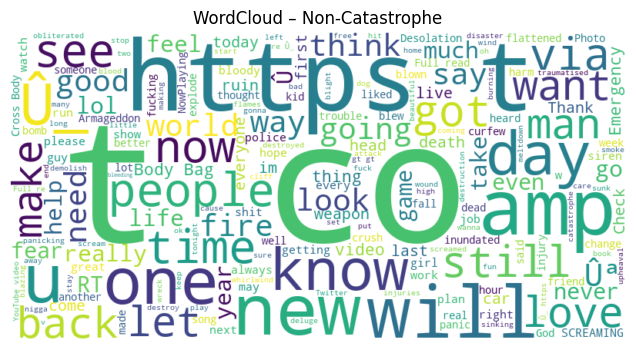

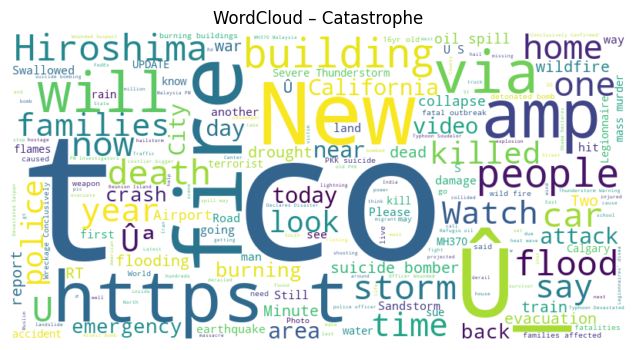

In [34]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["text"])
text_1 = " ".join(df_1["text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()

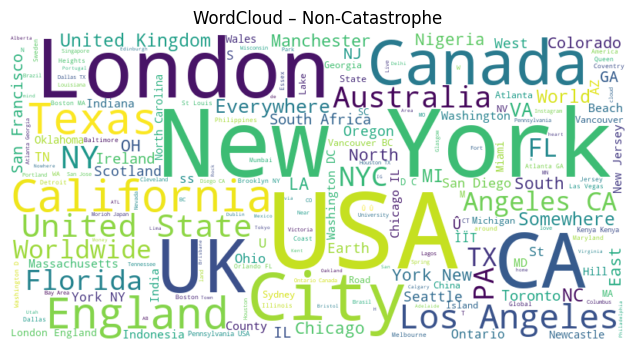

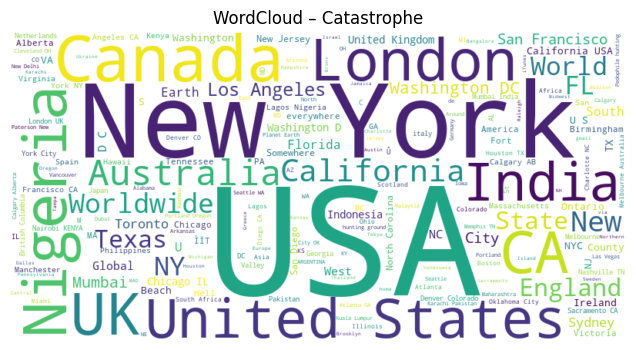

In [35]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["location"])
text_1 = " ".join(df_1["location"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()


## Analyse des features

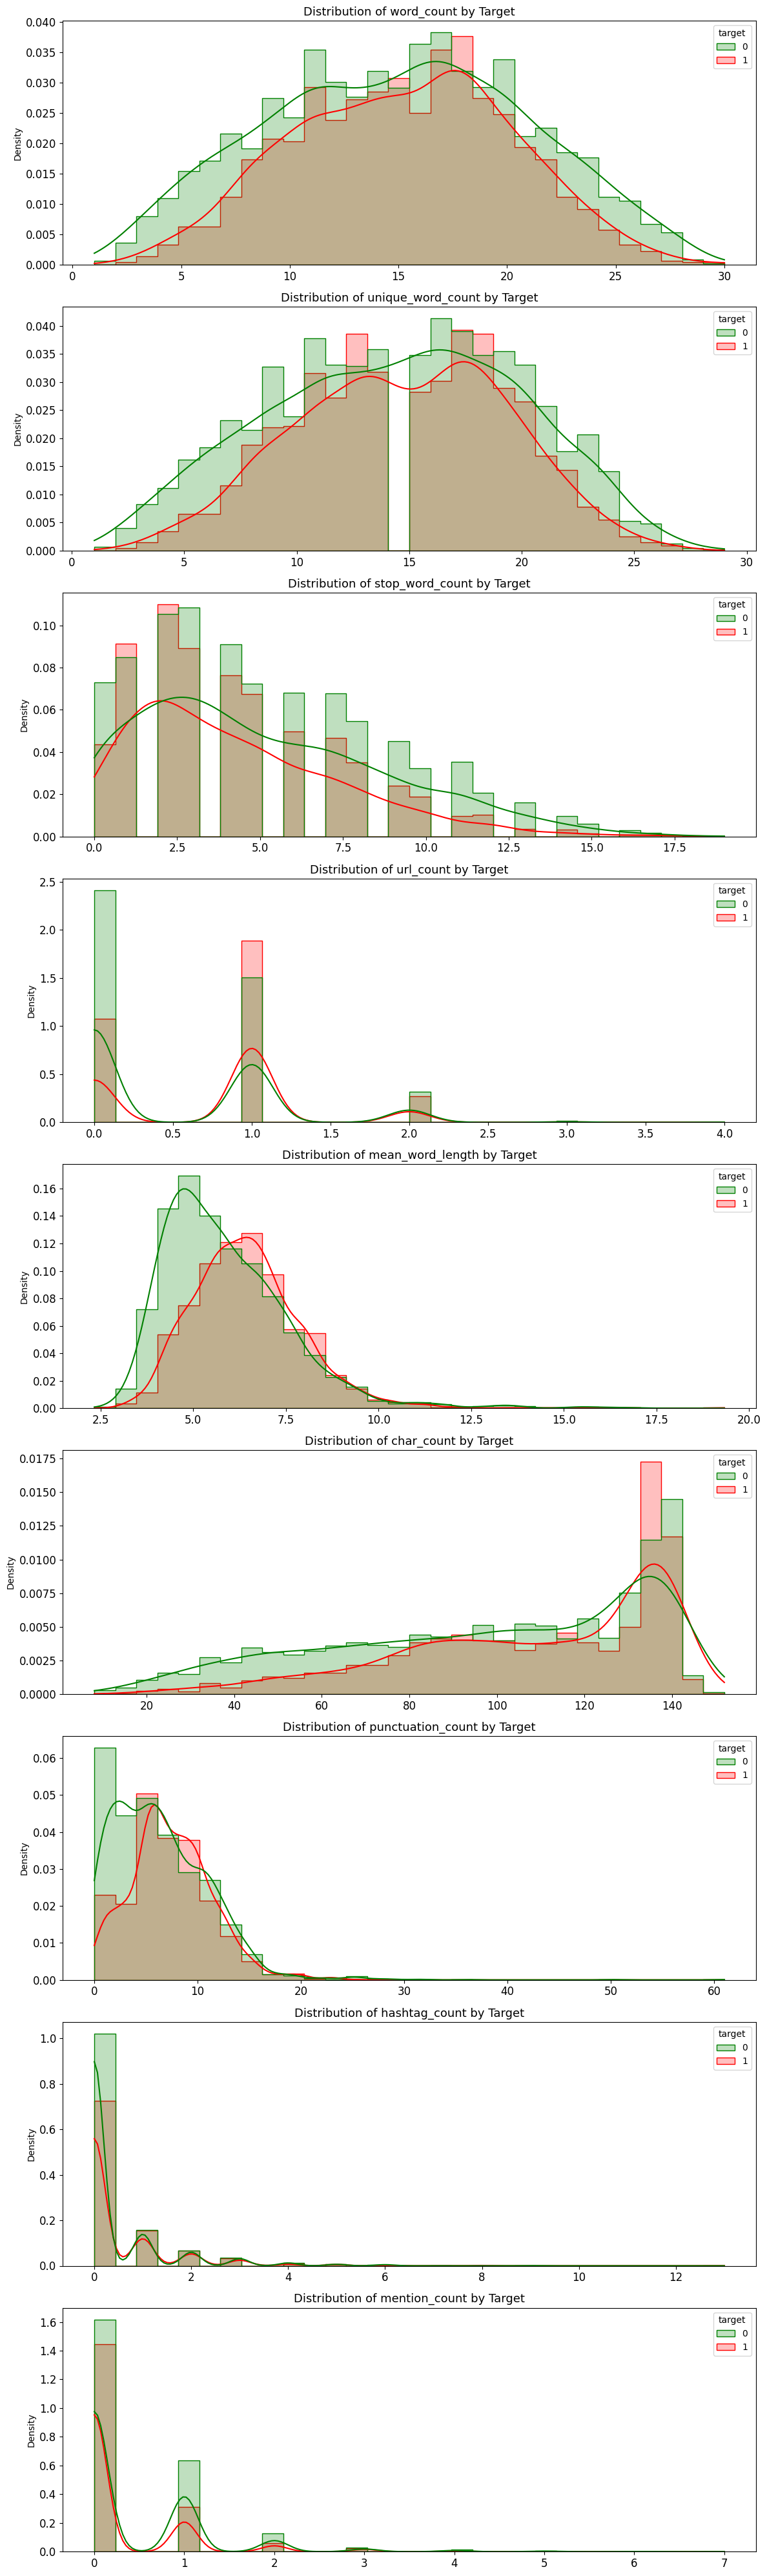

In [36]:
# Liste des features à analyser
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count',
                'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# Filtre pour les tweets liés à des catastrophes
DISASTER_TWEETS = df['target'] == 1

# Création de la figure avec sous-graphiques
fig, axes = plt.subplots(nrows=len(METAFEATURES), ncols=1, figsize=(12, 40), dpi=100)

# Pour chaque feature, on trace deux courbes : disaster vs non-disaster
for i, feature in enumerate(METAFEATURES):
    sns.histplot(data=df, x=feature, hue='target', kde=True, ax=axes[i], bins=30,
                 palette={0: "green", 1: "red"}, element="step", stat="density")
    
    axes[i].set_title(f'Distribution of {feature} by Target', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(1, 1), top_n=20):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(sorted_words[:top_n], columns=['ngram', 'count'])

In [38]:
def plot_all_ngrams(df, target_value):
    text_data = df[df['target'] == target_value]['text']

    bigrams = get_top_ngrams(text_data, ngram_range=(2, 2), top_n=20)
    trigrams = get_top_ngrams(text_data, ngram_range=(3, 3), top_n=20)
    quadgrams = get_top_ngrams(text_data, ngram_range=(4, 4), top_n=20)

    fig, axes = plt.subplots(1, 3, figsize=(22, 10))

    for ax, data, title in zip(
        axes,
        [bigrams, trigrams, quadgrams],
        ['Bigrammes', 'Trigrammes', 'Quadgrammes']
    ):
        ngram_df = pd.DataFrame(data, columns=['ngram', 'count'])
        sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
        ax.set_title(f"{title} pour target = {target_value}")
        ax.set_xlabel("Fréquence")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_d

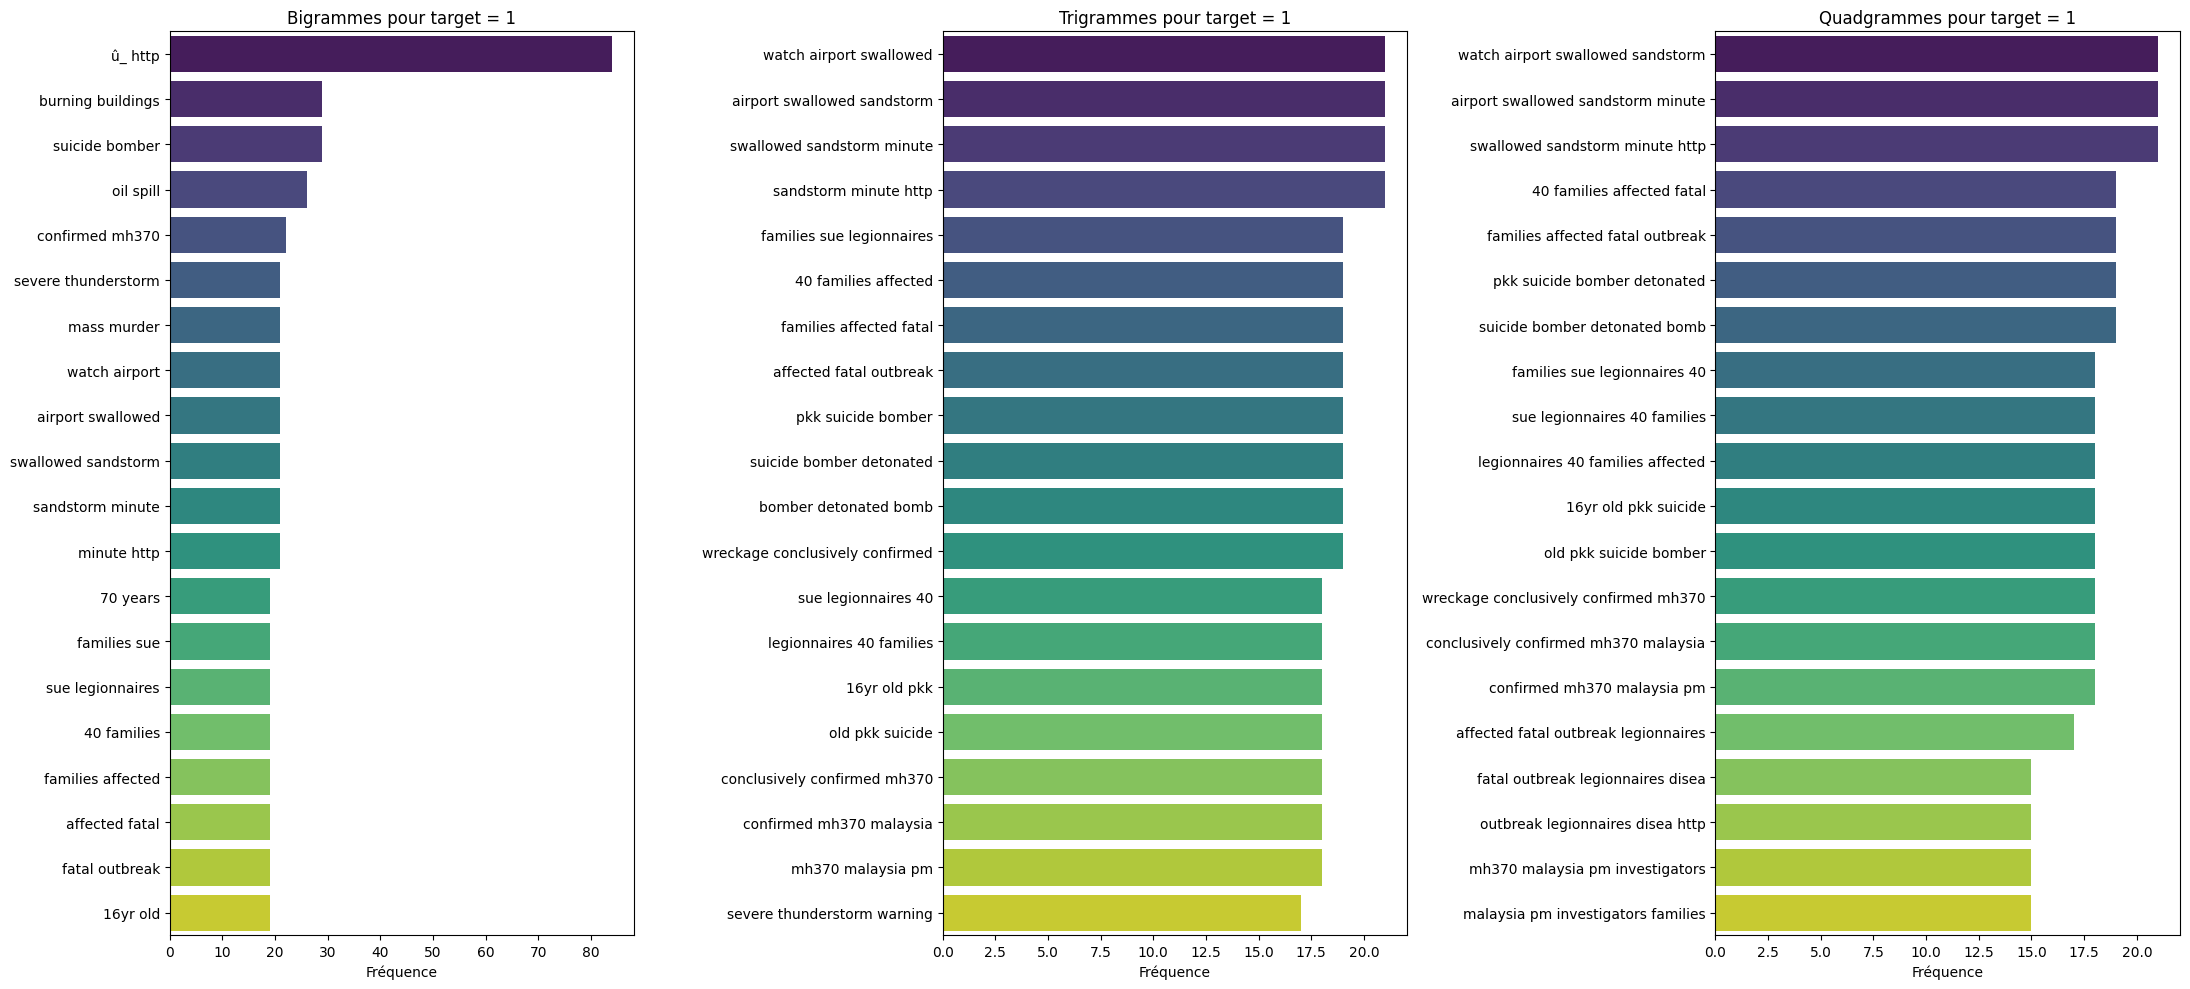

/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_d

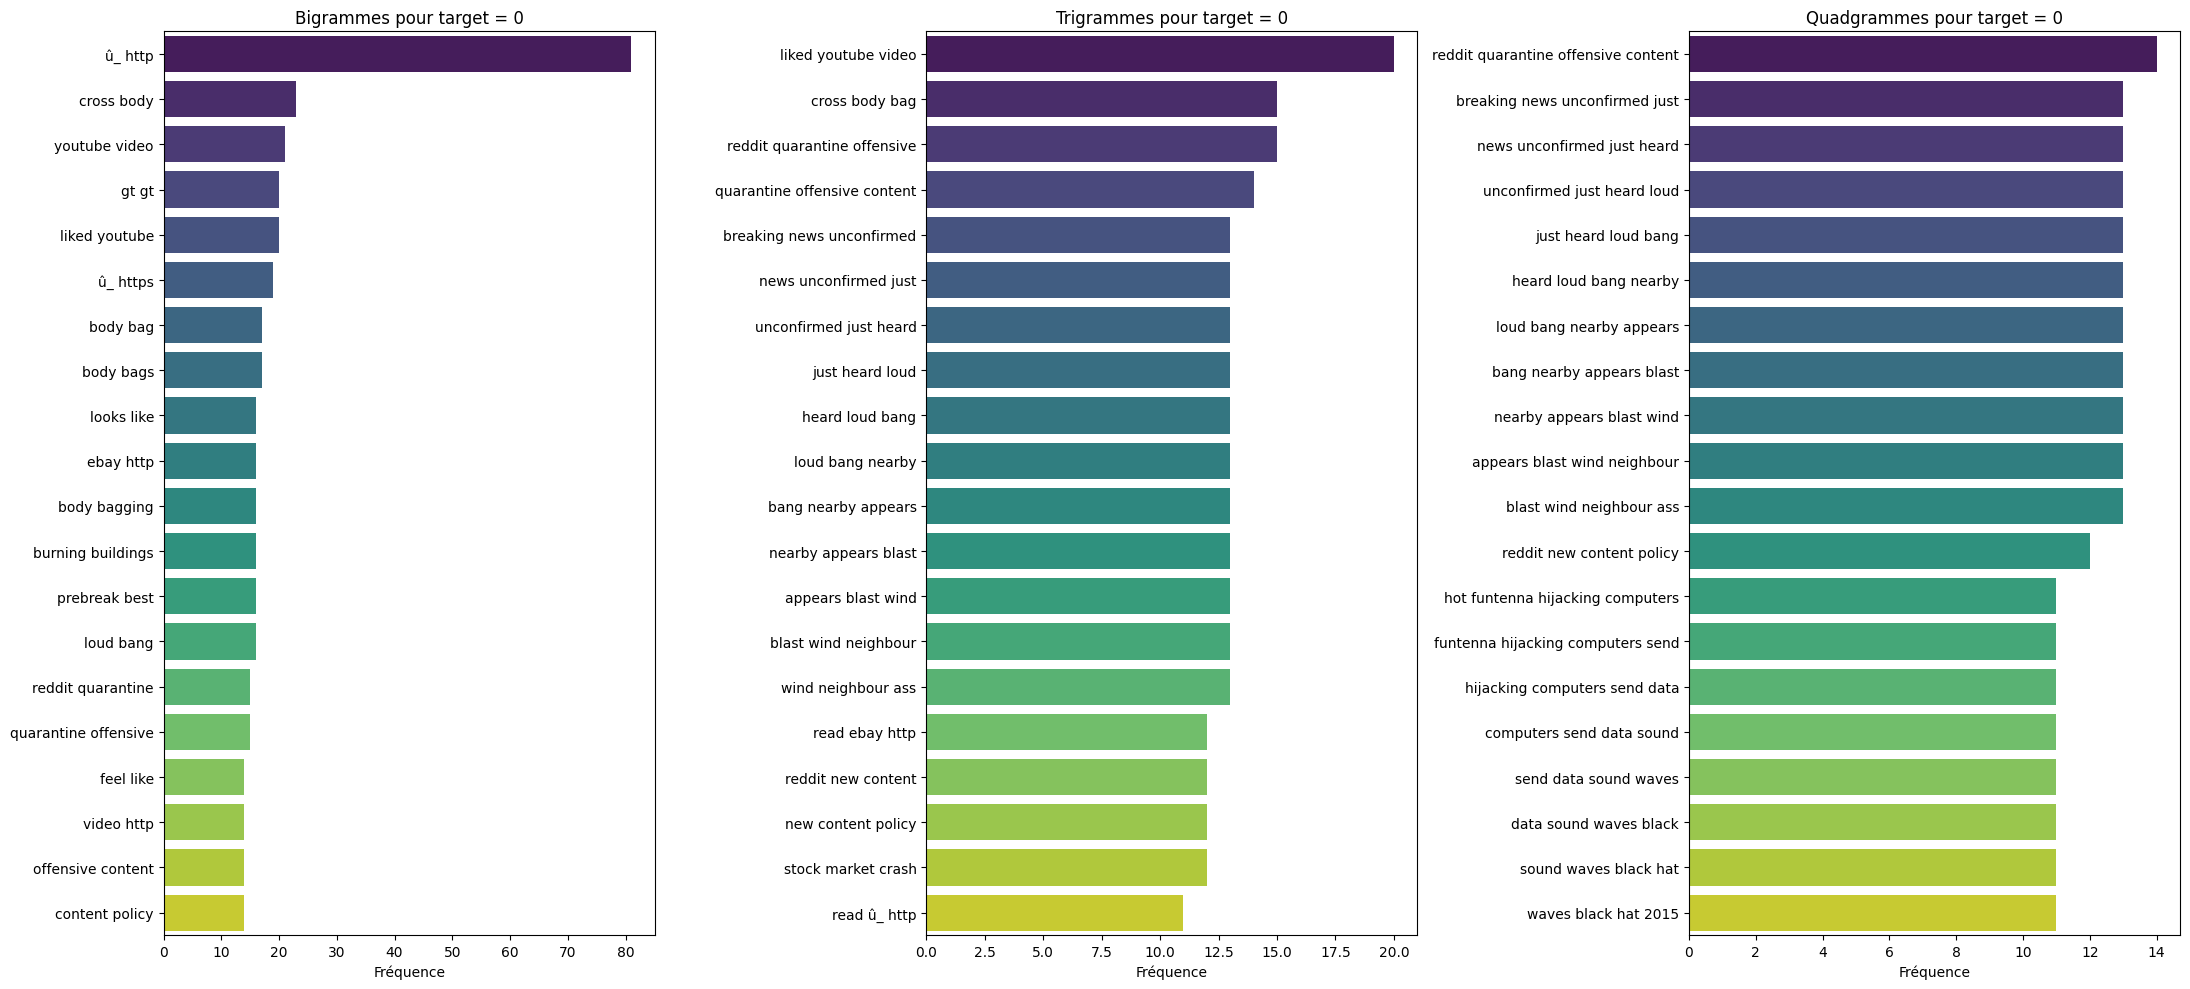

In [39]:
plot_all_ngrams(df, 1)  # Pour les tweets de catastrophe
plot_all_ngrams(df, 0)  # Pour les autres
